Import necessary packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from statsmodels.formula.api import ols
import statsmodels.api as sm

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
%matplotlib inline
%load_ext autoreload
%autoreload 2

from custom_functions import * #remove_extremes

Import dataset that was cleaned and prepared in Data Preparation notebook

In [2]:
conn = sqlite3.connect('../../data/processed/main.db')
query = '''SELECT * FROM step2_encoded'''
df_main = pd.read_sql(query, conn, index_col='index').reset_index(drop=True)
conn.close()

df_main.head(3)
y = 'SalePrice'

In [3]:
def remove_df_extremes(df, devct, drop_zeros=False):
    
    for col in df.columns:
        df[col] = [float(num) for num in df[col]]
        med = df[col].median()
        std = df[col].std()

        max_ = med + devct*std
        min_ = 0.0000001 if drop_zeros else med - devct*std 

        df[col] = [x if ((x>min_) & (x<max_)) else np.nan for x in df[col]]
    df.dropna(inplace=True)
    return df

In [4]:
def produce_model(df, x, y, devct, drop_zeros=False):
    model_data = pd.concat([df[y], df[x]], axis=1)
    model_data_trimmed = remove_df_extremes(model_data, devct, drop_zeros)

    formula = y + ' ~ ' + '+'.join(xs)
    
    #formula_TESTING = 'SalePrice ~ SqFtTotLiving+Bedrooms+YrBuilt+Condition+Stories'
    model = ols(formula, model_data_trimmed).fit()
    print(formula)
    
    return model, model_data_trimmed

In [5]:
def qq(df, col):
    plt.figure(figsize=(12,6));
    sm.graphics.qqplot(df[col], line='45', fit=True)
    plt.title(f'Normality Assumption Check: QQ plot of {col} values');

In [6]:
def dist(df, x):
    plt.figure(figsize=(12,6));
    sns.distplot(df[x])
    plt.title(f'Distribution of {x} (KDE)')

In [7]:
def scatter(df, x, model):
    plt.figure(figsize=(12, 6));
    sns.lmplot(data = df, x=x, y=y, line_kws={'color':'r'})    
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f'Linearity Assumption: {x} vs. {y}');

In [8]:
# STEPWISE SELECTOR
non_na = df_main.dropna()
X = non_na.drop(y, axis=1)
Y = non_na[y]
results = stepwise_selection(X, Y, verbose=False)
#results

In [13]:
df_main.drop(y, axis=1).columns

Index(['NbrLivingUnits', 'Stories', 'BldgGrade', 'SqFtTotLiving',
       'SqFtTotBasement', 'FinBasementGrade', 'SqFtGarageAttached',
       'DaylightBasement', 'SqFtOpenPorch', 'SqFtEnclosedPorch', 'SqFtDeck',
       'HeatSystem', 'HeatSource', 'BrickStone', 'ViewUtilization', 'Bedrooms',
       'YrBuilt', 'YrRenovated', 'Condition', 'SaleInstrument',
       'forced_air_vs_other', 'SqFtUnfinished', 'Bathrooms', 'Fireplaces'],
      dtype='object')

SalePrice ~ NbrLivingUnits+Stories+BldgGrade+SqFtTotLiving+SqFtTotBasement+SqFtGarageAttached+DaylightBasement+SqFtOpenPorch+SqFtDeck+HeatSource+ViewUtilization+Bedrooms+YrBuilt+YrRenovated+Condition+SaleInstrument+forced_air_vs_other+Bathrooms+Fireplaces


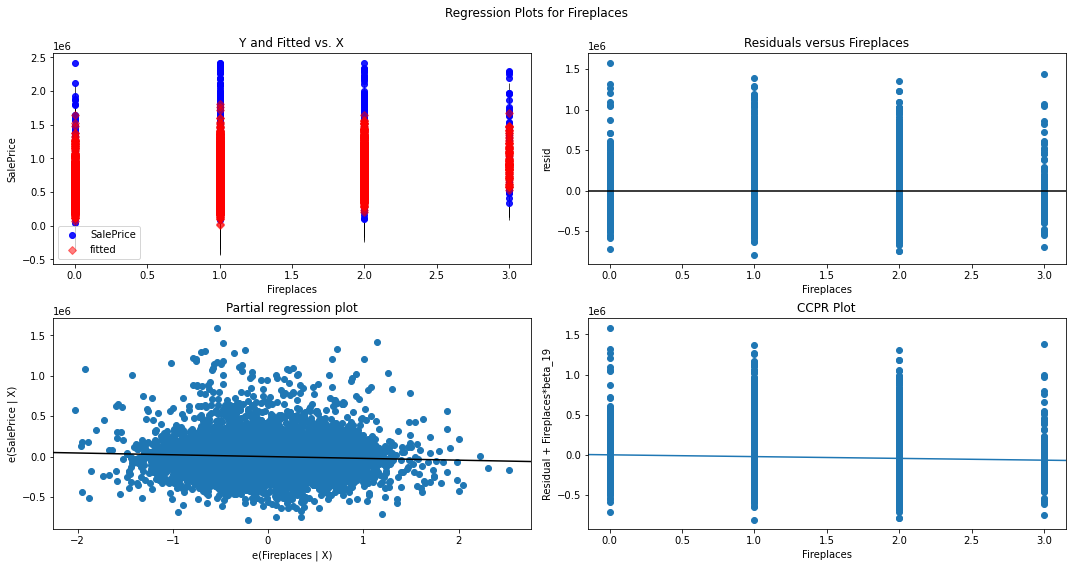

In [29]:
exclude_these_features = [y, 'SqFtEnclosedPorch', 'SqFtUnfinished', 'FinBasementGrade', 'HeatSystem', 'BrickStone']
xs = df_main.drop(exclude_these_features, axis=1).columns

model, df_trimmed = produce_model(df_main, xs, y, 3)
x = 'Fireplaces'


fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, x, fig=fig);

#model.summary()

# x = 'Fireplaces'
# qq(df_trimmed, x);
# dist(df_trimmed, x)
# scatter(df_trimmed, x, model)

In [ ]:
sm.graphics.plot_regress_exog(model, 'Bedrooms', fig=plt.figure(figsize=(12, 8)));

In [ ]:
df_main.columns

In [ ]:
#all_data = pd.concat([df_main[y], df_main[xs]], axis=1)
CorrMatrix = df_main.corr()


CorrMatrix = df_main.iloc[:, :10].corr()
plt.figure(figsize=(15,10))
sns.heatmap(CorrMatrix, annot=True)
plt.title('Correlation Matrix for First 10 Features');

CorrMatrix = pd.concat([df_main[y], df_main.iloc[:, 10:20]], axis=1).corr()
plt.figure(figsize=(15, 10))
sns.heatmap(CorrMatrix, annot=True)
plt.title('Correlation Matrix for Next 10 Features')

CorrMatrix = pd.concat([df_main[y], df_main.iloc[:, 20:]], axis=1).corr()
plt.figure(figsize=(15, 10))
sns.heatmap(CorrMatrix, annot=True)
plt.title('Correlation Matrix for Remaining Features')

In [ ]:
correlations = df_main.corr().stack().reset_index()
correlations = correlations.loc[(correlations.level_0 == 'SalePrice') & (correlations.level_1 != 'SalePrice')]
correlations[0] = correlations[0].abs()
correlations.columns = ['Dependent', 'Feature', 'Correlation (abs)']

correlations.sort_values(by='Correlation (abs)', ascending=False, inplace=True)
correlations.reset_index(inplace=True, drop=True)
listed = list(correlations.loc[correlations['Correlation (abs)'] > 0.1].Feature.values)

df_main[listed].info()